In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import matplotlib
import h5py

import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils
from utils import default_paths, nsd_utils
from utils import prf_utils;

from feature_extraction import texture_feature_utils

from model_fitting import initialize_fitting

from sklearn import decomposition

#### First, loading the complete matrix of [images x features]
This is just for the images shown to S01, we could use any other image set and get similar result

In [2]:
featpath = default_paths.pyramid_texture_feat_path

ss = 1

featfilename = os.path.join(featpath, 'PCA','S%d_4ori_4sf_pcaHL_concat_grid5.h5py'%ss)

image_inds = np.arange(10000)

with h5py.File(featfilename, 'r') as f:
    feats = f['/features'][image_inds,:,:]

Features are [n_images x n_features x n_pRFs]

In [3]:
feats.shape

(10000, 125, 1456)

#### Now load the corresponding COCO images, convert to grayscale for visualization

In [4]:
image_data = nsd_utils.get_image_data(subject=ss)
image_data = nsd_utils.image_uncolorize_fn(image_data)


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


#### Figure out which features are in which columns of the matrix
This is in a file that was created when we made the features

In [5]:
filename = os.path.join(default_paths.pyramid_texture_feat_path,'PCA', \
                            'S%d_4ori_4sf_featurelabels_pcaHL_grid5.npy' %(ss))
lab = np.load(filename, allow_pickle=True).item()
cols = lab['feature_column_labels'].astype(int)
names = lab['feature_type_names']
feature_type_names_raw = names
feature_column_labels_raw = cols

# for some of the feature subsets, there are multiple sub-groups in which PCA was performed
# separately. For these, I just picked one to plot (otherwise there are too many plots)
feat_inds_plot = np.array([0,1,2,3,5,7,8,9,10,11]).astype(int)

feature_type_names_simple = texture_feature_utils.feature_type_names_simple


#### Decide on a pRF to look at for the figure

In [6]:

# creating the whole grid of pRF parameters [x,y,sigma]
prf_params = np.round(initialize_fitting.get_prf_models(5),3)

target_pars = [0.1,-0.1,0.20]
mm = np.argmin(np.sum(np.abs(prf_params-target_pars), axis=1))

mm, prf_params[mm,:]

(750, array([ 0.12 , -0.12 ,  0.176], dtype=float32))

#### Visualize the pRF of interest

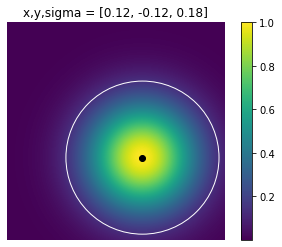

In [7]:

x,y,sigma = prf_params[mm,:]

n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)
prf_2d /= np.max(prf_2d)
center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure();
ax = plt.subplot(1,1,1)
plt.imshow(prf_2d)
plt.axis('off')
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));
plt.plot(center_in_image[0], center_in_image[1],'o',color='k')
circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                         color = 'w', fill=False)
ax.add_artist(circ)
plt.colorbar()

#### Plot the lower-level model features first
For these features, PCA isn't done yet so do it now to get top images

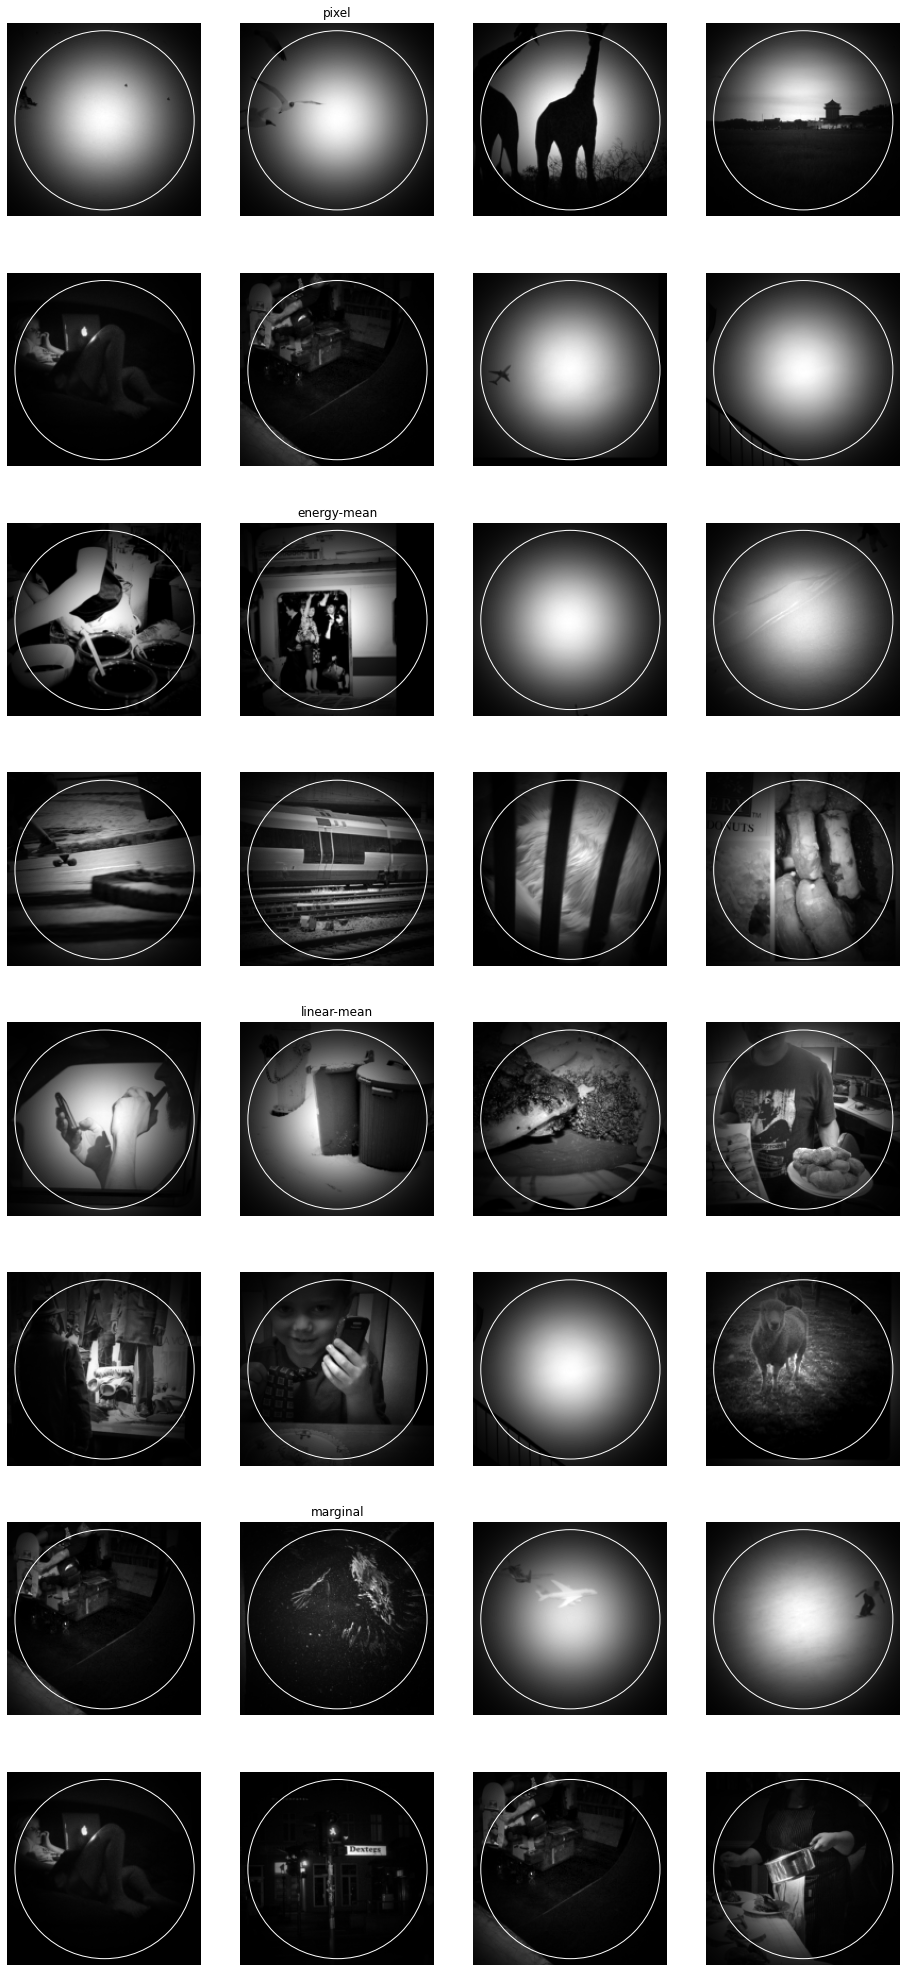

In [20]:
top_n = 2;

plt.figure(figsize=(16,36));

pi=0

xlims = [57,240] # going to crop images around the pRF, just for visualization
ylims = [240,57]

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

for fi, ff in zip(np.arange(4), feat_inds_plot[np.arange(4)]):

    feats_use = feats[:,feature_column_labels_raw==ff,mm]
   
    n_comp = 2;
        
    pca = decomposition.PCA(n_components = n_comp, copy=True)
    scores = pca.fit_transform(feats_use) 

    for pc in np.arange(0,n_comp):
        
        top_image_inds = np.flip(np.argsort(scores[:,pc]))[0:top_n]
        bottom_image_inds = np.argsort(scores[:,pc])[0:top_n]

        top_images = image_data[top_image_inds,0,:,:]
        bottom_images = image_data[bottom_image_inds,0,:,:]

        # plot top images
        for ii in range(top_n):
            pi+=1
            ax = plt.subplot(8,top_n*2,pi);
            
            # weighting the image by the pRF here
            im = (top_images[ii,:,:]) * (prf_2d);
            plt.imshow(im, cmap='gray')
            
            # add the pRF circle to the plot
            circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                         color = 'w', fill=False)
            ax.add_artist(circ)
            plt.axis('off')
            if ii==1 and pc==0:
                plt.title('%s'%(feature_type_names_simple[fi]))
            plt.xlim(xlims)
            plt.ylim(ylims)
            
        # and bottom images
        for ii in range(top_n):
            pi+=1
            ax = plt.subplot(8,top_n*2,pi);    
            im = (bottom_images[ii,:,:]) * (prf_2d);
            plt.imshow(im, cmap='gray')
            circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                         color = 'w', fill=False)
            ax.add_artist(circ)
            plt.axis('off')
            plt.xlim(xlims)
            plt.ylim(ylims)
           
fn2save = os.path.join(default_paths.fig_path, 'texture_prf_vis_lowerlevel.pdf')
plt.savefig(fn2save)

#### Now visualize top/bottom images for each of the higher-level feature PCs

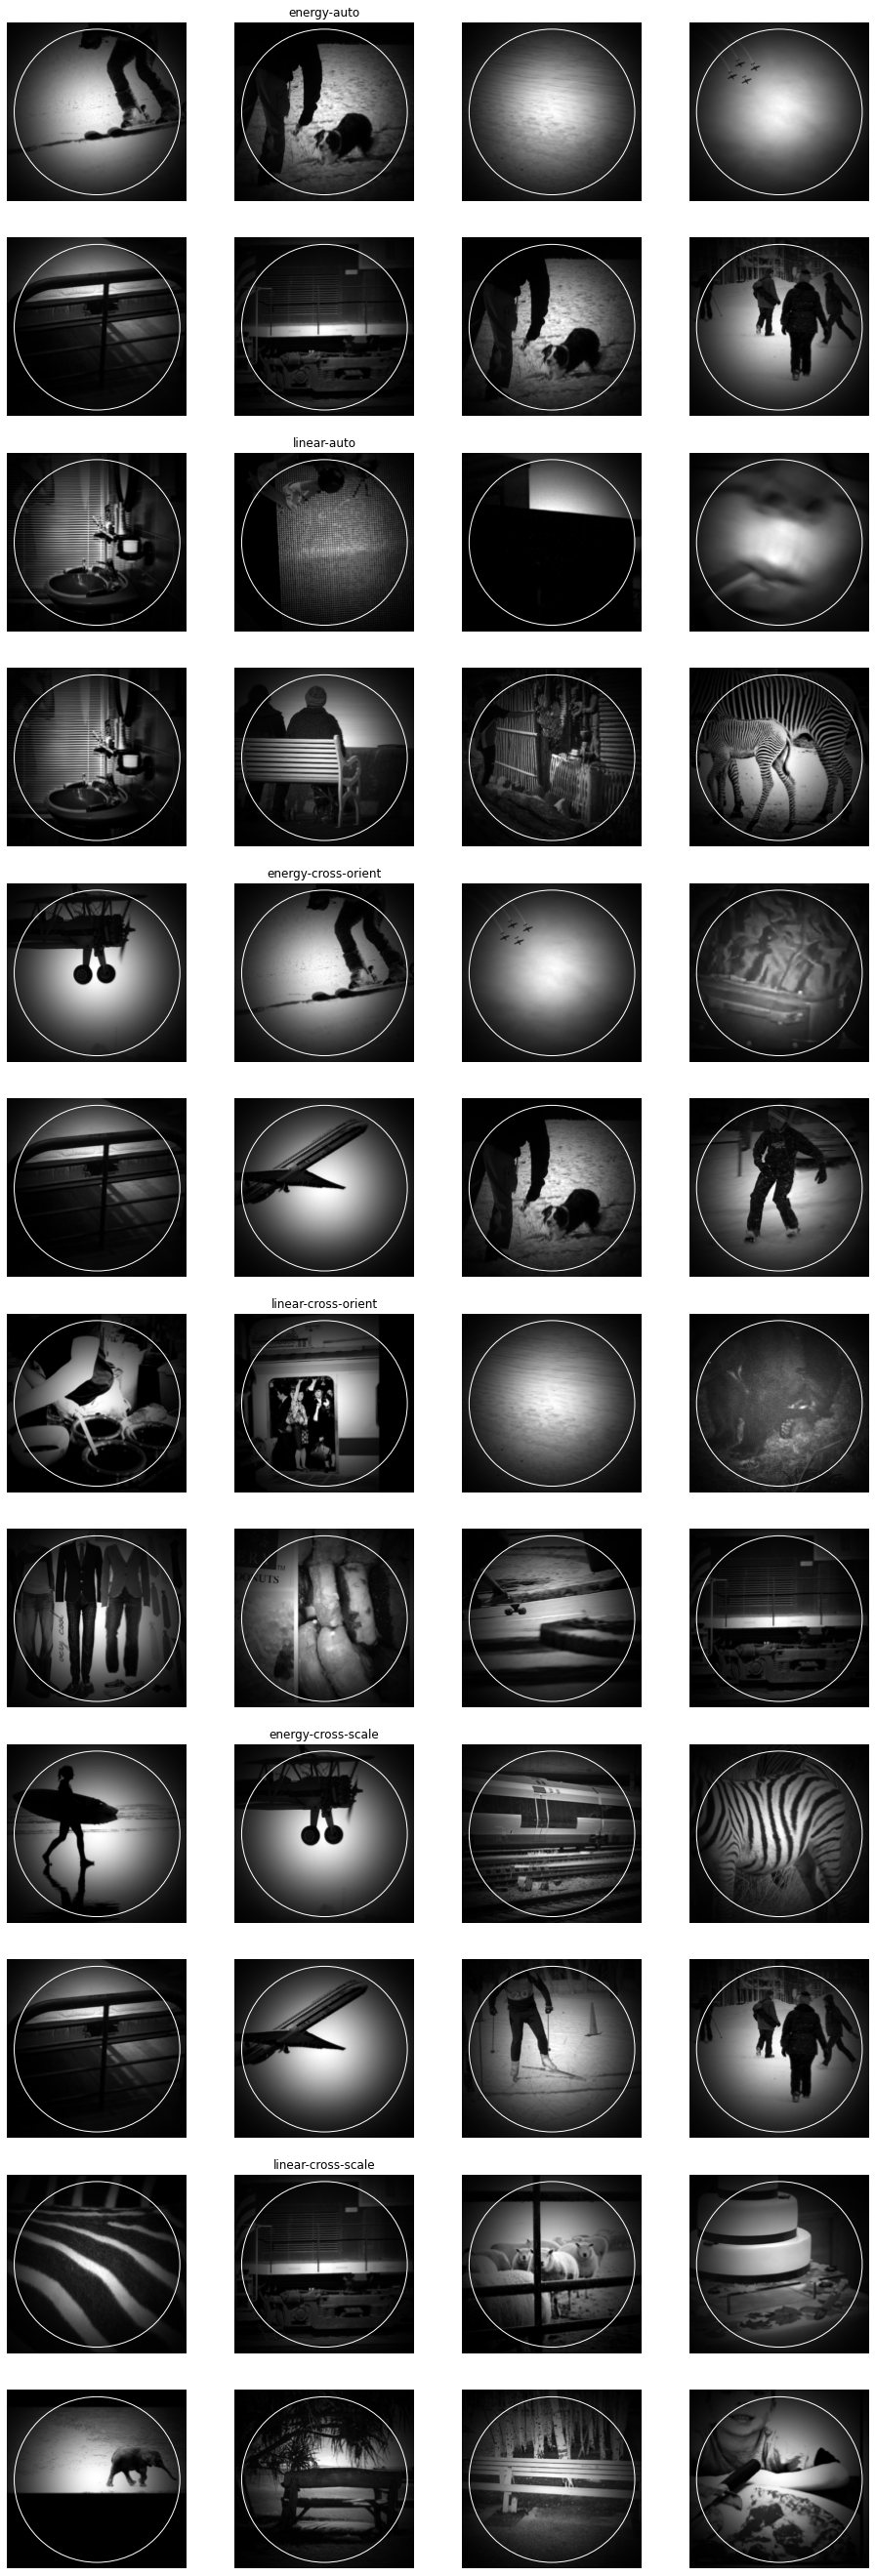

In [12]:
top_n = 2;

plt.figure(figsize=(16,4*12));

pi=0

# xlims=[0,240]
# ylims=[240,0]
xlims = [57,240]
ylims = [240,57]

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

for fi, ff in zip(np.arange(4,10), feat_inds_plot[np.arange(4,10)]):

    feats_use = feats[:,feature_column_labels_raw==ff,mm]
    
    for pc in np.arange(0,2):
        
        top_image_inds = np.flip(np.argsort(feats_use[:,pc]))[0:top_n]
        bottom_image_inds = np.argsort(feats_use[:,pc])[0:top_n]

        top_images = image_data[top_image_inds,0,:,:]
        bottom_images = image_data[bottom_image_inds,0,:,:]

        for ii in range(top_n):
            pi+=1
            ax = plt.subplot(12,top_n*2,pi);
            im = (top_images[ii,:,:]) * (prf_2d);
            # im = (top_images[ii,:,:])
            plt.imshow(im, cmap='gray')
            circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                         color = 'w', fill=False)
            ax.add_artist(circ)
            plt.axis('off')
            if ii==1 and pc==0:
                plt.title('%s'%(feature_type_names_simple[fi]))
            plt.xlim(xlims)
            plt.ylim(ylims)
            
        for ii in range(top_n):
            pi+=1
            ax = plt.subplot(12,top_n*2,pi);   
            im = (bottom_images[ii,:,:]) * (prf_2d);
            # im = (bottom_images[ii,:,:])
            plt.imshow(im, cmap='gray')
            circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                         color = 'w', fill=False)
            ax.add_artist(circ)
            plt.axis('off')
            plt.xlim(xlims)
            plt.ylim(ylims)
          
fn2save = os.path.join(default_paths.fig_path, 'texture_prf_vis_higherlevel.pdf')
plt.savefig(fn2save)